# Brian McKean 
# ===========
# BioTrak Health 
https://www.biotrakhealth.com/
##  Session Management
## Identify ineffective sessions during user trials
# ===========
## Galvanize Data Science Immersion
## Capstone Project

#### First data exploration

In [1]:
from docx import Document
from docx.shared import Inches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.parasite_axes import SubplotHost
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
import requests
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier



## Get Data from files

In [2]:
# Read in data
df_users = pd.read_json('users_02_26_2017.txt')
df_sessions = pd.read_json('sessions_02_26_2017.txt')
print df_users.columns
print df_sessions.columns

Index([u'YOB', u'_id', u'email', u'first_name', u'gender', u'last_name',
       u'userid'],
      dtype='object')
Index([u'Build#', u'Device_info_id', u'End_GMT_time', u'End_local_time',
       u'GMT_Date', u'GMT_date', u'Local_date', u'Session_data_header',
       u'Session_name', u'Session_name:', u'Session_time_interval',
       u'Session_type', u'Start_GMT_time', u'Start_local_time',
       u'Start_time_zone', u'User_info_id', u'Version#', u'_id',
       u'session_data', u'user_info_id', u'userid'],
      dtype='object')


### Initial Data Exploration




In [3]:
print len(df_users), " users are set up"
print len(df_sessions), "sessions are uploaded"

66  users are set up
356 sessions are uploaded


In [4]:
# Read Ratings File
df_ratings = pd.read_csv('data/ratings.csv')
print "Number of ratings is ",len(df_ratings)


Number of ratings is  356


In [5]:
print "Rated Bad:", df_ratings[df_ratings['rating']=='Bad'].count()

Rated Bad: Unnamed: 0     237
session_num    237
rating         237
dtype: int64


In [6]:
print "Rated Good:",df_ratings[df_ratings['rating']=='Good'].count()

Rated Good: Unnamed: 0     119
session_num    119
rating         119
dtype: int64


In [7]:
df_sessions = df_sessions.ix[:356,:]

#### Set up scoring

After a review session the project firmware engineer and I graded 356 sessions.  There were 237 bad and 119 good ratings. a

In addition to coming up with the ratings we jointly decided on some heuristics for determing a good and bad sessions

1. If the session was less than 60 seconds the session is bad. It is possible that a user may have an properly operating device over the 60 seconds, but we consider that not an effective use as there is not enough time to use the sessions as designed.  

2. If the session, after 60 seconds, goes to 0 (Min) or 4095 (Max), the session is bad.  Some of the sessions in this category show a significant amount of good data, but the fact that the user had problems idnicate someting that needs to be addressed.  
  * These two extremes indicate that an electrode has lost contact with the skin. Once a session has started the electrodes should continue to make proper contact until the end of the session.  
   
3. Low signal values are not a problem.  

4. Signal may be smooth with gradual peaks or there may be sharp peaks. The peaks come from activities such as jaw clenching that may be part of a session or may simply be the user exploring the operation of the device. 



#### Add New Features

In order to incororate the heuristics I add the following features

1. min_len (T/F) -- is the length at least 3600 units (60 seconds)
2. pegged_L (T/F) -- at least one value of 0 after 60 seconds
3. pegged_H (T/F) -- at least one value of 4095 afte 60 seconds

In [8]:
# add ratings to session data
df_sessions['rating'] = df_ratings['rating']

In [9]:
print df_sessions.columns


Index([               u'Build#',        u'Device_info_id',
                u'End_GMT_time',        u'End_local_time',
                    u'GMT_Date',              u'GMT_date',
                  u'Local_date',   u'Session_data_header',
                u'Session_name',         u'Session_name:',
       u'Session_time_interval',          u'Session_type',
              u'Start_GMT_time',      u'Start_local_time',
             u'Start_time_zone',          u'User_info_id',
                    u'Version#',                   u'_id',
                u'session_data',          u'user_info_id',
                      u'userid',                u'rating'],
      dtype='object')


A litte data exploration

In [10]:
df_sessions.Session_name.unique()

array([u'Open', u'Breathing for Relief', u'Head and Neck Relax',
       u'3 Minute Relax', u'Deep Breathing', u'Forest Visualization',
       u'Deep Relax for Sleep', u'Elevator Excercise',
       u'Beach Visualization', u'Cloud Visualization',
       u'Extended Exercise', u'Breath and Relax', u'Progress Muscle Relax'], dtype=object)

In [11]:
df_sessions.Session_type.unique()

array([u'open', u'managed'], dtype=object)

In [12]:
df_groups = df_sessions.groupby('Session_name') 

In [13]:
df_groups['Device_info_id'].count()

Session_name
3 Minute Relax            32
Beach Visualization        9
Breath and Relax           4
Breathing for Relief      10
Cloud Visualization        6
Deep Breathing             6
Deep Relax for Sleep       6
Elevator Excercise         7
Extended Exercise          1
Forest Visualization       6
Head and Neck Relax       10
Open                     257
Progress Muscle Relax      2
Name: Device_info_id, dtype: int64

In [14]:
df_results = df_sessions[['Session_name','userid']]

In [15]:
# Score is True if session is bad
# we are looking for bad sessions
df_results['score'] = np.where(df_sessions['rating']=='Good', False, True)

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


We have to change format for the time series data. It starts as a string of comma delimted values. The last value is uploaded incorrectly in some sessions so we discard it.

In [16]:
# Pull session data dictionary info into it's own clumns
dfNew = df_sessions.join(pd.DataFrame(df_sessions["session_data"].to_dict()).T)

In [17]:
dfNew.columns

Index([               u'Build#',        u'Device_info_id',
                u'End_GMT_time',        u'End_local_time',
                    u'GMT_Date',              u'GMT_date',
                  u'Local_date',   u'Session_data_header',
                u'Session_name',         u'Session_name:',
       u'Session_time_interval',          u'Session_type',
              u'Start_GMT_time',      u'Start_local_time',
             u'Start_time_zone',          u'User_info_id',
                    u'Version#',                   u'_id',
                u'session_data',          u'user_info_id',
                      u'userid',                u'rating',
                u'average_data',    u'average_data_count',
               u'baseline_data',         u'data_interval',
                  u'final_data',          u'graphed_data',
          u'graphed_data_count',              u'raw_data',
              u'raw_data_count'],
      dtype='object')

In [18]:
# Start calculation of features
# Convert session data from string to array of ints
# -- Drop the last entry as there was a bug that put in a bad last entry
temp = dfNew['average_data'].str.replace(" ","").str.split(',').str[:-1].map(lambda xx: np.array([int(yy) for yy in xx]))

In [19]:
# Some of the time series are empty, if so insert an entry of one sample at 0
# Signal is inverted -- need to change it 
temp = temp.map(lambda x: np.array( [0] if not len(x) else x ))
temp = temp.map(lambda x: 4095 - x)

In [20]:
# Get the mean
temp2 = temp.map(lambda x: x.mean())

In [21]:
temp2.fillna(0,inplace=True)
df_results['avg_data_mean'] = temp2

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
# Get the max
t_max = temp.map(lambda x: x.max())

In [23]:
df_results['avg_data_max'] = t_max

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [24]:
# Get the min
df_results['avg_data_min'] = temp.map(lambda x: x.min())

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
# Get the length
df_results['avg_data_len'] = temp.map(lambda x: len(x))

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
# Get the standard deviation
df_results['avg_data_std'] = temp.map(lambda x: x.std())

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [27]:
df_results.columns

Index([ u'Session_name',        u'userid',         u'score', u'avg_data_mean',
        u'avg_data_max',  u'avg_data_min',  u'avg_data_len',  u'avg_data_std'],
      dtype='object')

In [28]:
# Load in session num 
df_results['session_num'] = df_results.index

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [29]:
# Add heuristics
df_results['min_len'] = df_results['avg_data_len']>3600
df_results['pegged_low'] = [False if (len(x)<3600 or min(x[3600:])>0) else True for x in temp]
df_results['pegged_high'] = [False if (len(x)<3600 or max(x[3600:])<4095) else True for x in temp]

/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/brianmckean/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [30]:
df_results.columns

Index([ u'Session_name',        u'userid',         u'score', u'avg_data_mean',
        u'avg_data_max',  u'avg_data_min',  u'avg_data_len',  u'avg_data_std',
         u'session_num',       u'min_len',    u'pegged_low',   u'pegged_high'],
      dtype='object')

In [31]:
df_key_columns = [x  for x in list(df_results.columns) if x not  in ['Session_name','userid','score']]
print df_key_columns

['avg_data_mean', 'avg_data_max', 'avg_data_min', 'avg_data_len', 'avg_data_std', 'session_num', 'min_len', 'pegged_low', 'pegged_high']


In [32]:
df_res_save = df_results.copy()

In [33]:
y = df_results['score'].as_matrix()
X_df = df_results[df_key_columns]
X = X_df.as_matrix()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [35]:
df_results.describe()

,avg_data_mean,avg_data_max,avg_data_min,avg_data_len,avg_data_std,session_num
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,2080.052353,3521.893258,1021.233146,13404.457865,602.631308,177.500000
std,997.930074,883.259504,1220.579913,34697.181848,424.079052,102.912584
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1317.220337,3357.250000,0.000000,1152.000000,264.431434,88.750000
50%,2090.857233,3901.000000,423.000000,3736.000000,508.647631,177.500000
75%,2837.760875,4047.000000,1945.250000,13222.000000,939.515026,266.250000
max,4095.000000,4095.000000,4095.000000,382019.000000,1667.963040,355.000000


In [36]:
clf = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train,y_train)


In [37]:

scores = cross_val_score(clf, X_train, y_train, cv=10)

In [38]:
print scores
print scores.mean()

[ 0.83333333  0.79166667  0.95833333  0.91666667  0.79166667  0.875
  0.95833333  0.875       0.82608696  0.82608696]
0.865217391304


In [39]:
pred = clf.predict(X_train)

In [40]:
print clf.feature_importances_

for i in range(len(clf.feature_importances_)):
    print X_df.columns[i], clf.feature_importances_[i]
    
clf_save = clf
clf_name_save = X_df.columns
X_save = X_df.as_matrix()

[ 0.07482741  0.05206467  0.09356981  0.28436927  0.10351105  0.08949767
  0.15199783  0.14889914  0.00126317]
avg_data_mean 0.074827409527
avg_data_max 0.0520646674285
avg_data_min 0.0935698076556
avg_data_len 0.284369266812
avg_data_std 0.10351104636
session_num 0.0894976678294
min_len 0.151997825363
pegged_low 0.148899139956
pegged_high 0.00126316906828


In [41]:
pred_test = clf.predict(X_test)

In [42]:
clf.score(X_test,y_test)

0.92372881355932202

In [43]:
clf.get_params


<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)>

In [44]:
y_prob = clf.predict_proba(X_test)[:,1:]

In [45]:
missed = np.where([pred_test != y_test])[1]

In [46]:
for idx in missed:
    print df_results.iloc[idx]['session_num']

10
20
29
56
64
67
71
88
115


In [47]:
for i in range(len(missed)):
    print i, clf.predict_proba(X_test)[i]

0 [ 0.  1.]
1 [ 0.  1.]
2 [ 0.7  0.3]
3 [ 0.  1.]
4 [ 0.  1.]
5 [ 0.2  0.8]
6 [ 0.  1.]
7 [ 0.  1.]
8 [ 0.8  0.2]


In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

In [49]:
print precision, recall, thresholds

[ 0.75238095  0.84615385  0.90588235  0.94805195  0.97260274  1.          1.
  1.          1.          1.          1.        ] [ 1.          0.97468354  0.97468354  0.92405063  0.89873418  0.88607595
  0.87341772  0.83544304  0.82278481  0.65822785  0.        ] [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


In [50]:
df = pd.DataFrame()

In [51]:
df['precision'] = precision

In [52]:
print len(precision), len(recall), len(thresholds)
thresholds = np.append(thresholds,1.0)
print len(precision), len(recall), len(thresholds)

11 11 10
11 11 11


In [53]:
df['recall'] = recall
df['thresholds'] = thresholds

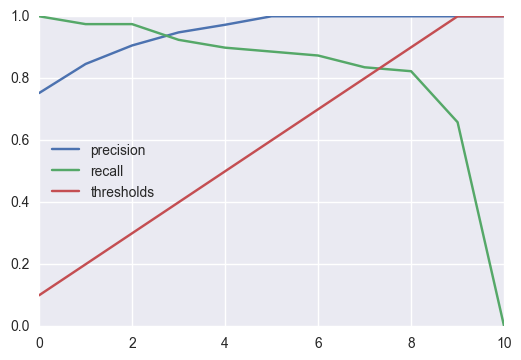

In [54]:
%matplotlib inline
df.plot()

In [55]:
byScore = df_results.groupby('score').count()

In [56]:
print byScore['avg_data_min']

score
False    119
True     237
Name: avg_data_min, dtype: int64


In [57]:

## Add in the cycles and largest swing features

def count_crosses(s, pts=10, intv=600):
    '''
    Looks at series
    for each 'intv' points
    - count crossings of 'pts' lookback moving average
    INPUTS:
        s = list of measurements
        pts = how many pts to collect for moving average
        intv = interval to measure crossing (600 = 10 sec)
    OUTPUTS
        crossings / intv = average crossing per interval
        biggest_move = on a crossing biggest move

    '''
    if len(s) < intv:
        return 0, 0
    if pts >= intv:
        return 0,0
    s = np.array(s)
    crossing_counts = [0]  
    index = pts
    max_swing = 0
    up = True # True for last cross up, False for down
    while (index + intv < len(s)):
        #print index
        interval_crossings = 0
        for i in range(intv):
            last_n = s[index-pts:index]
            avg = last_n.mean()
            if up and s[index] < avg:
                up = False
                interval_crossings += 1
                swing = abs(s[index]-s[index-1])
                if swing > max_swing:
                    max_swing = swing
            if not up and s[index] > avg:
                up = True
                interval_crossings += 1
                swing = abs(s[index]-s[index-1])
                if swing > max_swing:
                    max_swing = swing
            index += 1
        crossing_counts.append(interval_crossings)
   
    time_sec = intv/60.0
    return np.array(crossing_counts).mean()/(2*time_sec), max_swing
            
            
            

In [58]:
df_results3 = df_res_save.copy()
cycles = []
swings = []

look_back = [1]
#look_back = [3]

for look in look_back:
    c = []
    s = []
    for idx, elem in enumerate(temp):
        a,b = count_crosses(elem, pts=look)
        c.append(a)
        s.append(b)
    cycles.append(c)
    swings.append(s)
    df_results3['cycles_{0}'.format(look)] = c
    df_results3['swings_{0}'.format(look)] = s
    
    #plt.hist(cycles)
    #plt.hist(swings)
        

In [59]:
#df_results3

In [60]:
df4 = df_results.copy()
df4['cycles_1'] = df_results3['cycles_1']
df4['swings_1'] = df_results3['swings_1']

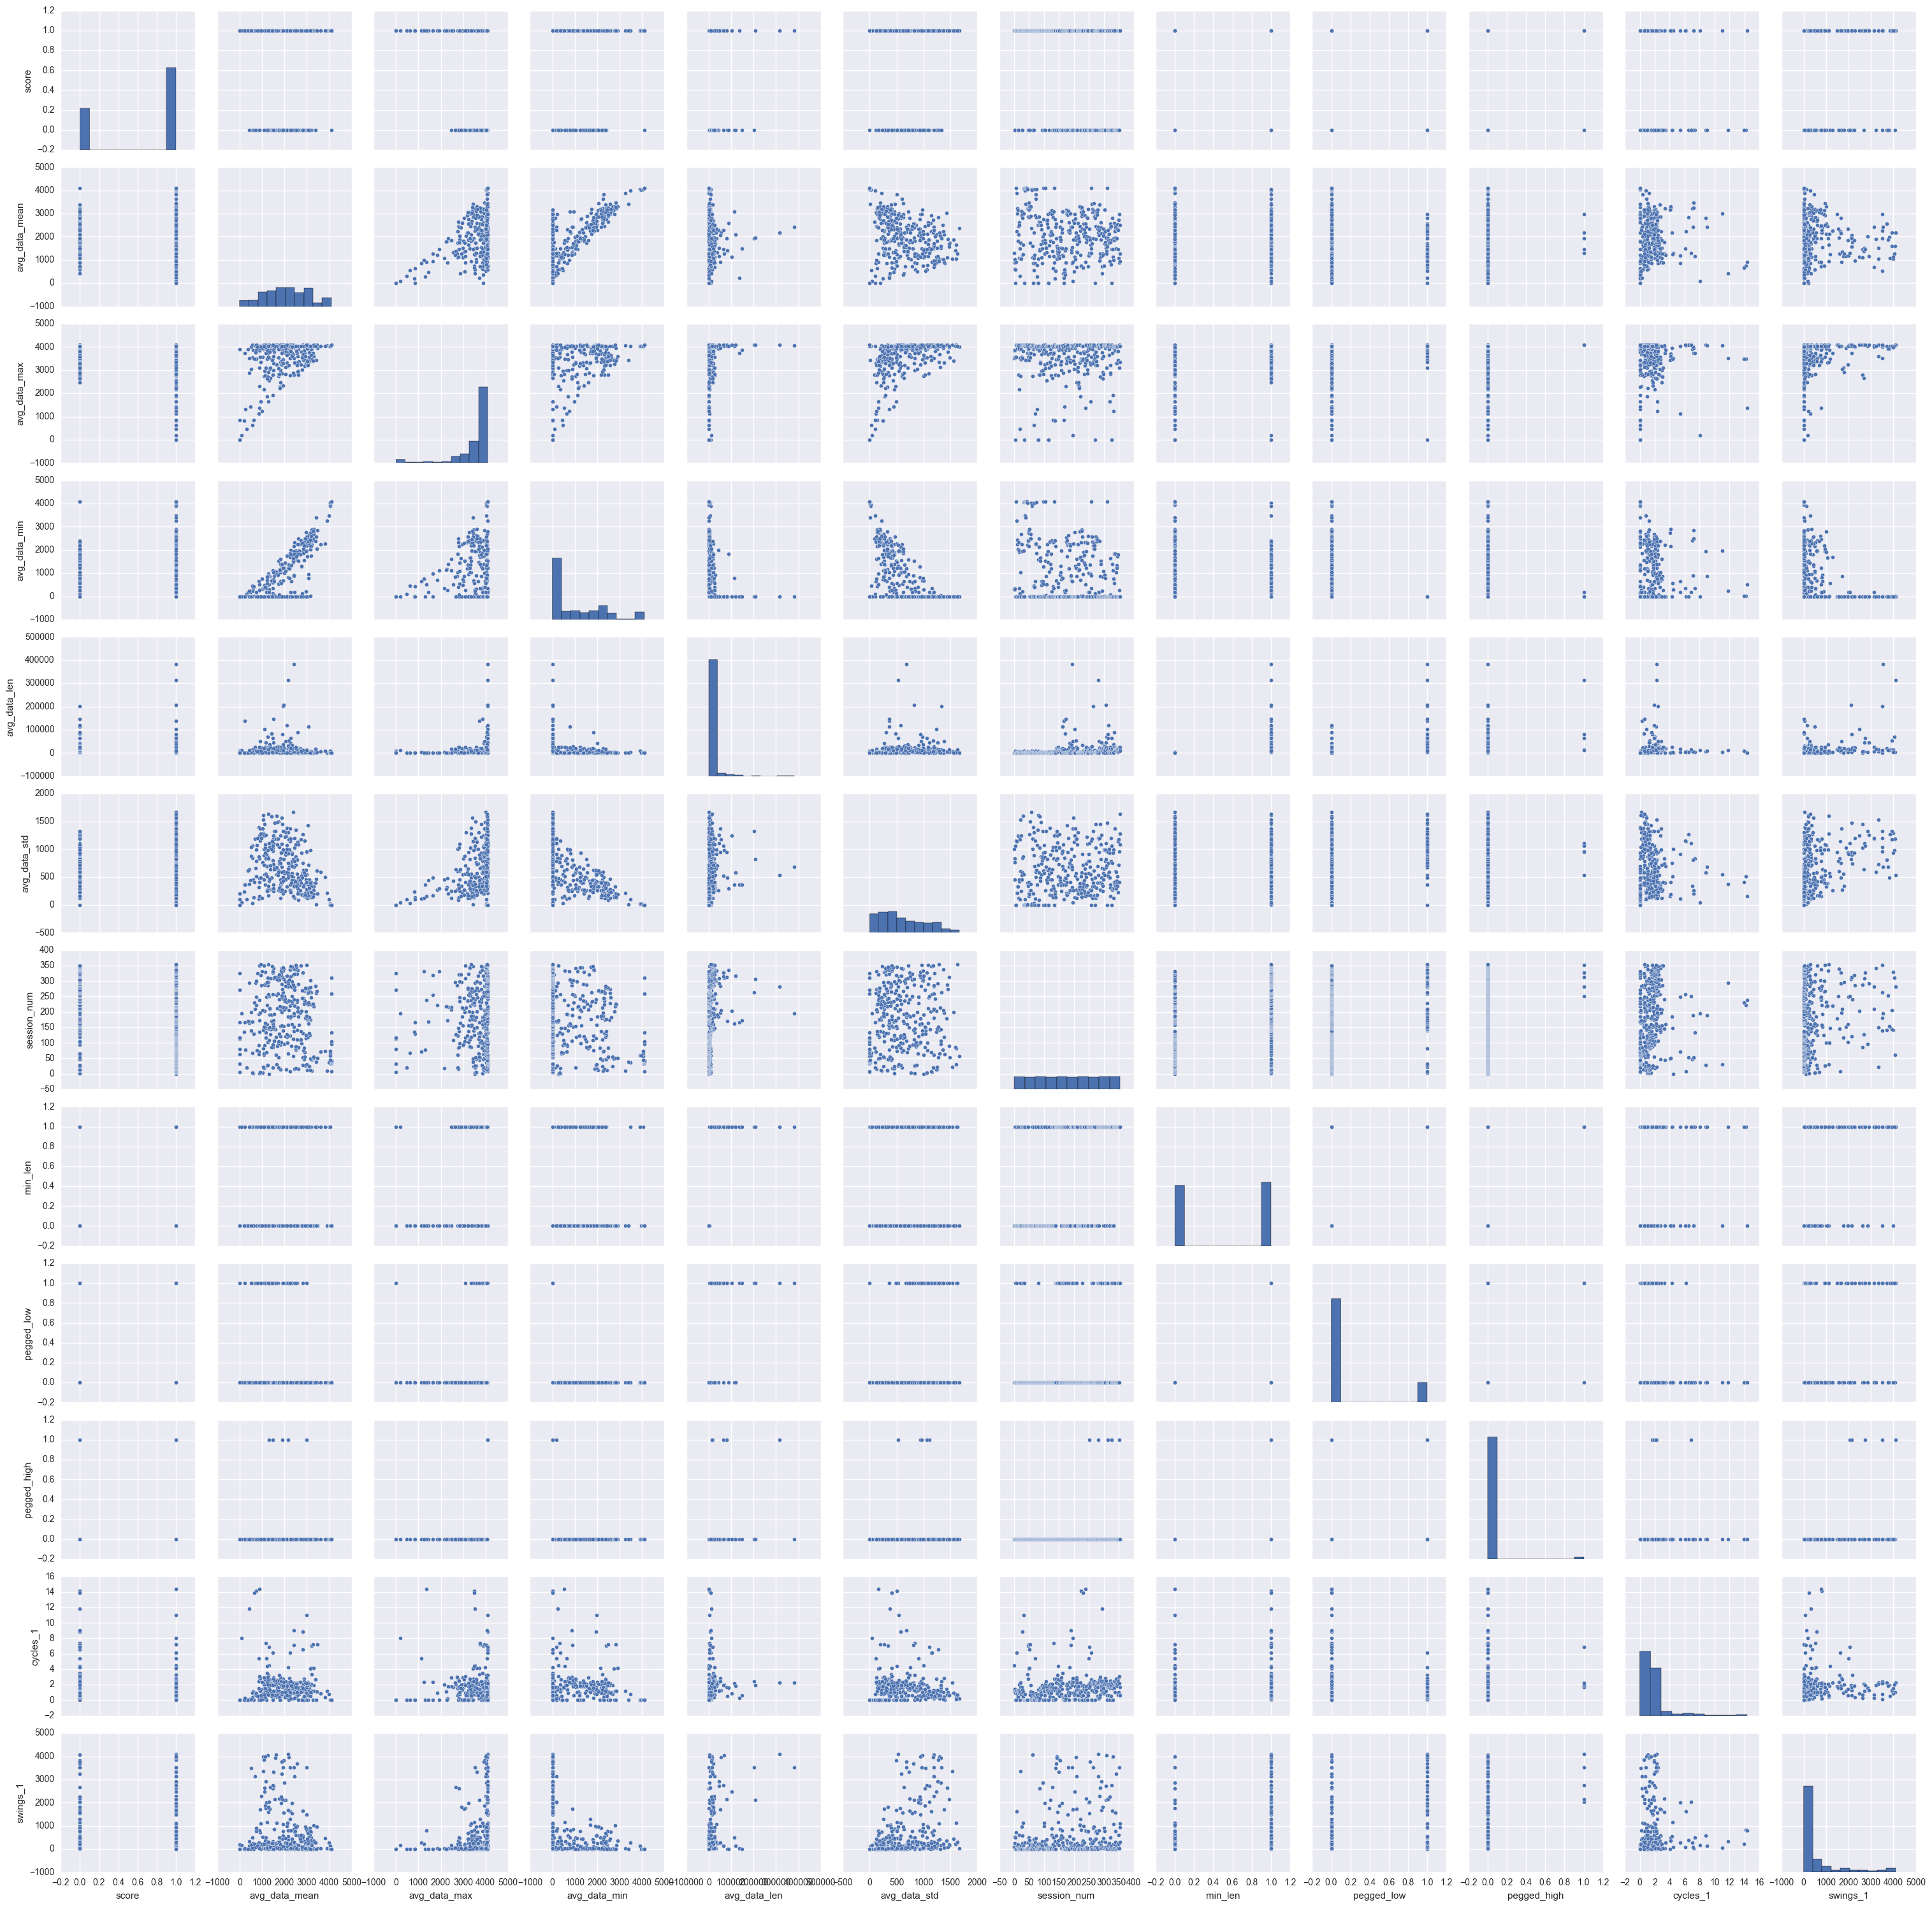

In [61]:
sns_plot = sns.pairplot(df4)
sns_plot.savefig("sns-pairplot.png")

In [62]:
y2 = df4['score'].as_matrix()
X_df2 = df4[['avg_data_mean',
        'avg_data_max',  'avg_data_min',  'avg_data_std', 'avg_data_len',
            'cycles_1','swings_1','min_len','pegged_low','pegged_high']]
X2 = X_df2.as_matrix()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.33, random_state=42)

In [64]:
clf = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train,y_train)
clf = clf.fit(X_train, y_train)


In [65]:
clf_save = clf
clf_name_save = X_df2.columns
X_save = X_df2.as_matrix()

In [66]:

scores = cross_val_score(clf, X_train, y_train, cv=10)

In [67]:
print scores
print np.average(scores)

[ 0.79166667  0.95833333  0.875       0.875       0.875       0.95833333
  0.91666667  0.95833333  0.82608696  0.82608696]
0.886050724638


In [68]:
print clf.feature_importances_

for i in range(len(clf.feature_importances_)):
    print X_df2.columns[i], clf.feature_importances_[i]

[ 0.07064774  0.05054319  0.09737334  0.10564576  0.25162631  0.1348587
  0.0572746   0.13476878  0.09468364  0.00257796]
avg_data_mean 0.070647739072
avg_data_max 0.050543185561
avg_data_min 0.0973733381049
avg_data_std 0.10564575551
avg_data_len 0.251626310731
cycles_1 0.134858702122
swings_1 0.0572745976741
min_len 0.134768777261
pegged_low 0.094683635819
pegged_high 0.00257795814473


In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
print precision, recall, thresholds

[ 0.75238095  0.84615385  0.90588235  0.94805195  0.97260274  1.          1.
  1.          1.          1.          1.        ] [ 1.          0.97468354  0.97468354  0.92405063  0.89873418  0.88607595
  0.87341772  0.83544304  0.82278481  0.65822785  0.        ] [ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


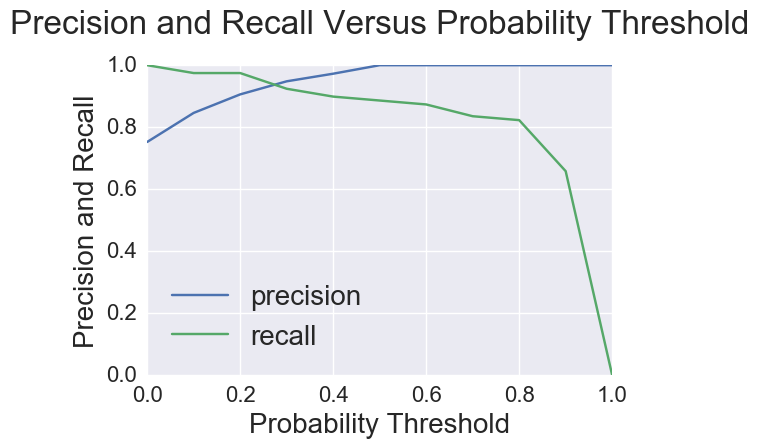

In [70]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Precision and Recall',fontsize=20)
x1 = np.arange(0,10)/5.0
#ax.plot(x1,df['precision'])
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Testing'
ax.plot(df['precision'])
ax.plot(df['recall'])
#ax.plot(df['thresholds'])
ax.set_xlim(0,10)
#labels = 
ax.set_xticklabels(x1)
ax.set_title('Precision and Recall Versus Probability Threshold',fontsize=24,y=1.08)
ax.set_xlabel('Probability Threshold',fontsize=20)
#plt.ylabel('Density',fontsize=18)
#plt.title('Average Frequency in Tension Measurement', fontsize=24)
ax.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=20,loc=0)
plt.show()
plt.savefig('prec-recall.png',bbox_inches='tight')

In [71]:
df4_t = df4[df4['score']==True]

In [72]:
df4_f = df4[df4['score']==False]

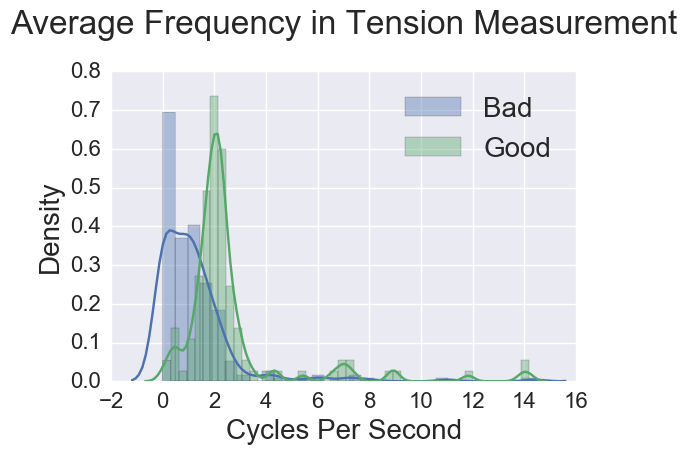

In [73]:
# Set up the matplotlib figure

sns.distplot( df4_t['cycles_1'], label = 'Bad')
sns.distplot( df4_f['cycles_1'], label = 'Good')
plt.xlabel('Cycles Per Second',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.title('Average Frequency in Tension Measurement', fontsize=24, y=1.10)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=20)
plt.savefig('feat-freq.png',bbox_inches='tight')

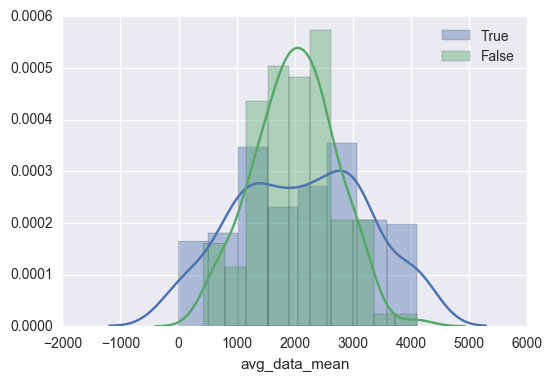

In [74]:
sns.distplot( df4_t['avg_data_mean'],label = 'True')
sns.distplot( df4_f['avg_data_mean'], label = 'False')
plt.legend()

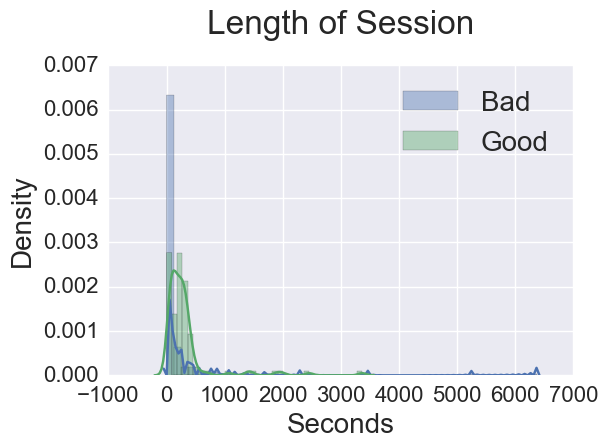

In [75]:
sns.distplot( df4_t['avg_data_len']/60.0,label = 'Bad')
sns.distplot( df4_f['avg_data_len']/60.0, label = 'Good')
plt.xlabel('Seconds',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.title('Length of Session', fontsize=24, y=1.08)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=20)
plt.savefig('feat-session-length.png',bbox_inches='tight')

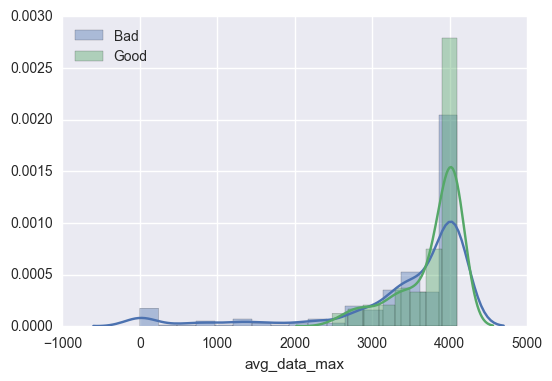

In [76]:
sns.distplot( df4_t['avg_data_max'],label = 'Bad')
sns.distplot( df4_f['avg_data_max'], label = 'Good')
plt.legend(loc=0)

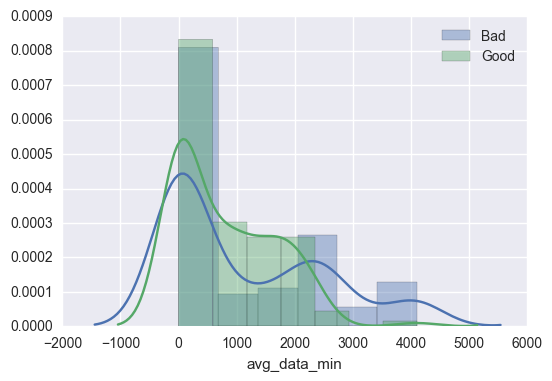

In [77]:
sns.distplot( df4_t['avg_data_min'],label = 'Bad')
sns.distplot( df4_f['avg_data_min'], label = 'Good')
plt.legend()

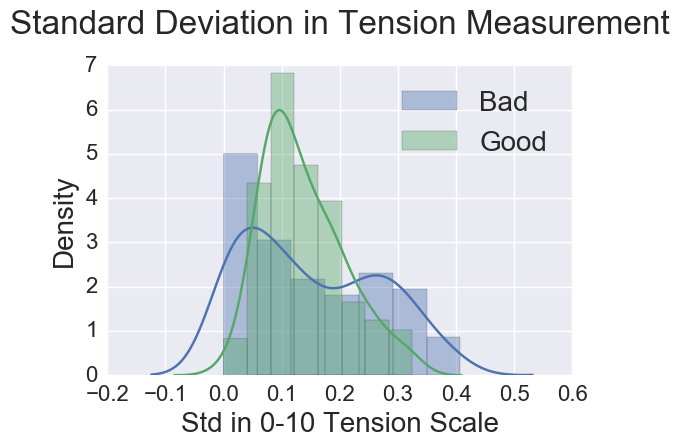

In [78]:
sns.distplot( df4_t['avg_data_std']/4095.0,label = 'Bad')
sns.distplot( df4_f['avg_data_std']/4095.0, label = 'Good')
plt.xlabel('Std in 0-10 Tension Scale',fontsize=20)
plt.ylabel('Density',fontsize=20)
plt.title('Standard Deviation in Tension Measurement', fontsize=24,y=1.08)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=20)
plt.savefig('feat-std.png',bbox_inches='tight')

In [79]:

good = [len(np.where(df4_f['avg_data_std']<=60)[0]),
            len(np.where(df4_f['avg_data_std']>60)[0]) ]


bad = [len(np.where(df4_t['avg_data_std']<=60)[0]),
            len(np.where(df4_t['avg_data_std']>60)[0]) ]

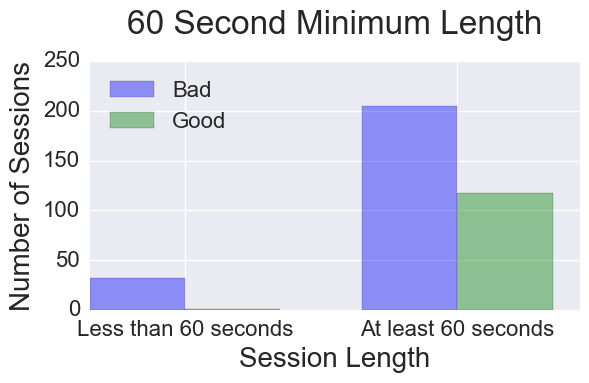

In [80]:
fig, ax = plt.subplots()

index = np.arange(2)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}


rects1 = plt.bar(index, 
                 bad, 
                 bar_width,
                 alpha=opacity,
                 color='b',
                 label='Bad')

rects2 = plt.bar(index + bar_width,
                 good,  
                 bar_width,
                 alpha=opacity,
                 color='g',
                 label='Good')

plt.xlabel('Session Length',fontsize=20)
plt.ylabel('Number of Sessions',fontsize=20)
plt.title('60 Second Minimum Length',fontsize=24,y=1.08)
plt.xticks(index + bar_width , ('Less than 60 seconds', 'At least 60 seconds'))
plt.legend(fontsize=16, loc=0)
plt.tick_params(axis='both',labelsize=16)
plt.tight_layout()
plt.show()
plt.savefig('feat-60-sec_min.png',bbox_inches='tight')

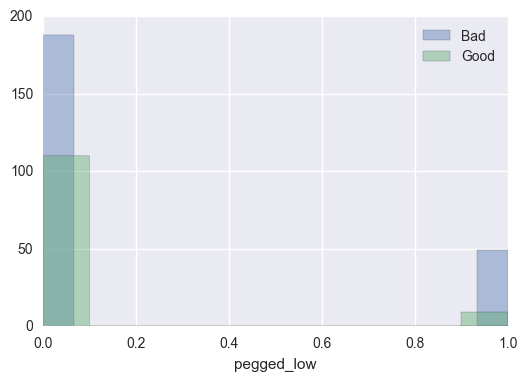

In [81]:
sns.distplot( df4_t['pegged_low'],kde=False, label = 'Bad')
sns.distplot( df4_f['pegged_low'],kde=False, label = 'Good')

plt.legend()

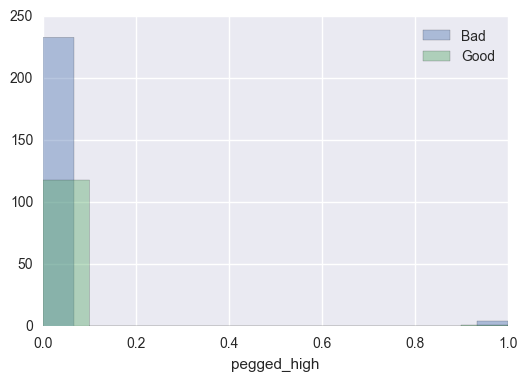

In [82]:
sns.distplot( df4_t['pegged_high'],kde=False, label = 'Bad')
sns.distplot( df4_f['pegged_high'], kde=False, label = 'Good')
plt.legend()

In [83]:
# Set up the matplotlib figure
df4.columns


Index([ u'Session_name',        u'userid',         u'score', u'avg_data_mean',
        u'avg_data_max',  u'avg_data_min',  u'avg_data_len',  u'avg_data_std',
         u'session_num',       u'min_len',    u'pegged_low',   u'pegged_high',
            u'cycles_1',      u'swings_1'],
      dtype='object')

In [84]:
clf = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train,y_train)

scores = cross_val_score(clf, X_train, y_train, cv=10)
print scores
print np.average(scores)

[ 0.79166667  0.95833333  0.875       0.875       0.875       0.95833333
  0.91666667  0.95833333  0.82608696  0.82608696]
0.886050724638


In [85]:

joblib.dump(clf, 'brtakrf_class.pkl') 

['brtakrf_class.pkl']

In [86]:
clfab = AdaBoostClassifier(base_estimator=None, 
 n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', 
                           random_state=42).fit(X_train,y_train)

In [87]:
scores_ab = cross_val_score(clfab, X_train, y_train, cv=10)
print scores_ab
print np.average(scores_ab)


[ 0.79166667  0.91666667  0.95833333  0.875       0.875       0.875       0.875
  0.875       0.7826087   0.7826087 ]
0.860688405797


In [88]:
clfgb = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                    n_estimators=100, subsample=1.0, 
                    criterion='friedman_mse', min_samples_split=2, 
                    min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                    max_depth=3, min_impurity_split=1e-07, init=None, 
                    random_state=42, max_features=None, 
                    verbose=0, max_leaf_nodes=None, 
                    warm_start=False, presort='auto').fit(X_train,y_train)

In [89]:
scores_gb = cross_val_score(clfgb, X_train, y_train, cv=10)
print scores_gb
print np.average(scores_gb)

[ 0.875       0.91666667  0.91666667  0.875       0.91666667  0.91666667
  0.83333333  0.91666667  0.86956522  0.91304348]
0.894927536232


In [90]:
scores_rf = cross_val_score(clf, X_train, y_train, cv=10)
print scores_rf

[ 0.79166667  0.95833333  0.875       0.875       0.875       0.95833333
  0.91666667  0.95833333  0.82608696  0.82608696]


In [91]:
RF_pred = clf.predict(X2)

In [92]:
df4['RF_pred'] = RF_pred

In [93]:
y2 = df4['score'].as_matrix()
X_df2 = df4[['avg_data_mean',
        'avg_data_max',  'avg_data_min',  'avg_data_std', 'avg_data_len',
            'cycles_1','swings_1','min_len','pegged_low','pegged_high','RF_pred']]
X2 = X_df2.as_matrix()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.33, random_state=42)

In [95]:
clfab = AdaBoostClassifier(base_estimator=None, n_estimators=50, 
            learning_rate=1.0, algorithm='SAMME.R', random_state=42).fit(X_train,y_train)

scores_ab = cross_val_score(clfab, X_train, y_train, cv=10)
print scores_ab
print np.average(scores_ab)

[ 1.          1.          1.          0.95833333  1.          1.
  0.95833333  1.          1.          0.95652174]
0.98731884058


In [96]:
scores_ab = cross_val_score(clfab, X_test, y_test, cv=10)
print scores_ab
print np.average(scores_ab)

[ 0.91666667  0.83333333  1.          0.91666667  1.          0.91666667
  0.91666667  0.91666667  1.          0.9       ]
0.931666666667


In [97]:
clfgb = GradientBoostingClassifier(loss='deviance', 
            learning_rate=0.1, n_estimators=100, subsample=1.0, 
            criterion='friedman_mse', min_samples_split=2,
            min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
            max_depth=3, min_impurity_split=1e-07, init=None, 
            random_state=42, max_features=None, verbose=0, 
            max_leaf_nodes=None, warm_start=False, presort='auto').fit(X_train,y_train)
scores_gb = cross_val_score(clfgb, X_train, y_train, cv=10)
print scores_gb
print np.average(scores_gb)

[ 1.          1.          1.          0.95833333  1.          1.          1.
  1.          1.          0.95652174]
0.991485507246


In [98]:
scores_gb = cross_val_score(clfgb, X_test, y_test, cv=10)
print scores_gb
print np.average(scores_gb)

[ 0.83333333  0.83333333  0.91666667  1.          1.          0.91666667
  0.91666667  1.          1.          0.9       ]
0.931666666667


In [99]:
joblib.dump(clf, 'brtakgb_class.pkl') 

['brtakgb_class.pkl']

In [100]:
trial_users = pd.read_csv('TrialUsers.csv', header=None)

In [101]:
df_trial = df4[df_results['userid'].isin(trial_users[0]) |df_results['userid'].str.contains('pilot') ]

In [102]:
y_trial = df_trial['score'].as_matrix()
X_trial_df = df_trial[['avg_data_mean',
        'avg_data_max',  'avg_data_min',  'avg_data_std', 'avg_data_len', 
            'cycles_1','swings_1','min_len','pegged_low','pegged_high']]

In [103]:
X_trial = X_trial_df.as_matrix()

In [104]:
trial_score = clf.score(X_trial, y_trial)
print trial_score

0.96875


In [105]:
X_trial_df2= X_trial_df.copy()
X_trial_df2['RF_pred'] = clf.predict(X_trial)
X_trial2 = X_trial_df2.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(
    X_trial2, y_trial, test_size=0.33, random_state=42)


In [106]:
trial_score_gb = clfgb.score(X_trial2, y_trial)
print trial_score_gb

0.96875


In [107]:
trial_score_ab = clfab.score(X_trial2, y_trial)
print trial_score_ab

0.96875


In [108]:
clfab.feature_importances_

array([ 0.04,  0.14,  0.06,  0.22,  0.08,  0.  ,  0.1 ,  0.  ,  0.  ,
        0.  ,  0.36])

In [109]:
len(X_trial[0])

10

In [110]:
print df_trial.columns
len(df_trial.columns)

Index([ u'Session_name',        u'userid',         u'score', u'avg_data_mean',
        u'avg_data_max',  u'avg_data_min',  u'avg_data_len',  u'avg_data_std',
         u'session_num',       u'min_len',    u'pegged_low',   u'pegged_high',
            u'cycles_1',      u'swings_1',       u'RF_pred'],
      dtype='object')


15

In [111]:
print X_df.columns
print X_df2.columns
print X_trial_df.columns
print X_trial_df2.columns

Index([u'avg_data_mean', u'avg_data_max', u'avg_data_min', u'avg_data_len',
       u'avg_data_std', u'session_num', u'min_len', u'pegged_low',
       u'pegged_high'],
      dtype='object')
Index([u'avg_data_mean', u'avg_data_max', u'avg_data_min', u'avg_data_std',
       u'avg_data_len', u'cycles_1', u'swings_1', u'min_len', u'pegged_low',
       u'pegged_high', u'RF_pred'],
      dtype='object')
Index([u'avg_data_mean', u'avg_data_max', u'avg_data_min', u'avg_data_std',
       u'avg_data_len', u'cycles_1', u'swings_1', u'min_len', u'pegged_low',
       u'pegged_high'],
      dtype='object')
Index([u'avg_data_mean', u'avg_data_max', u'avg_data_min', u'avg_data_std',
       u'avg_data_len', u'cycles_1', u'swings_1', u'min_len', u'pegged_low',
       u'pegged_high', u'RF_pred'],
      dtype='object')


In [112]:
print 'Bad=',len([x  for x in y_trial if x==True])
print 'Good=',len([x  for x in y_trial if x==False])

Bad= 33
Good= 31


In [113]:
y_pred2 = clfgb.predict(X_trial2)

In [114]:
print 'Bad=',len([x  for x in y_pred2 if x==True])
print 'Good=',len([x  for x in y_pred2 if x==False])

Bad= 31
Good= 33


In [115]:
right = y_trial == y_pred2

In [116]:
print 'Correct=',len([x  for x in right if x==True])
print 'Incorrect=',len([x  for x in right if x==False])

Correct= 62
Incorrect= 2


In [117]:
y_pred2 = clf.predict(X_trial)
right = y_trial == y_pred2
print 'Correct=',len([x  for x in right if x==True])
print 'Incorrect=',len([x  for x in right if x==False])

Correct= 62
Incorrect= 2


In [118]:
#df_trial[df_trial['score']!=df_trial['RF_pred']]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Text yticklabel objects>)

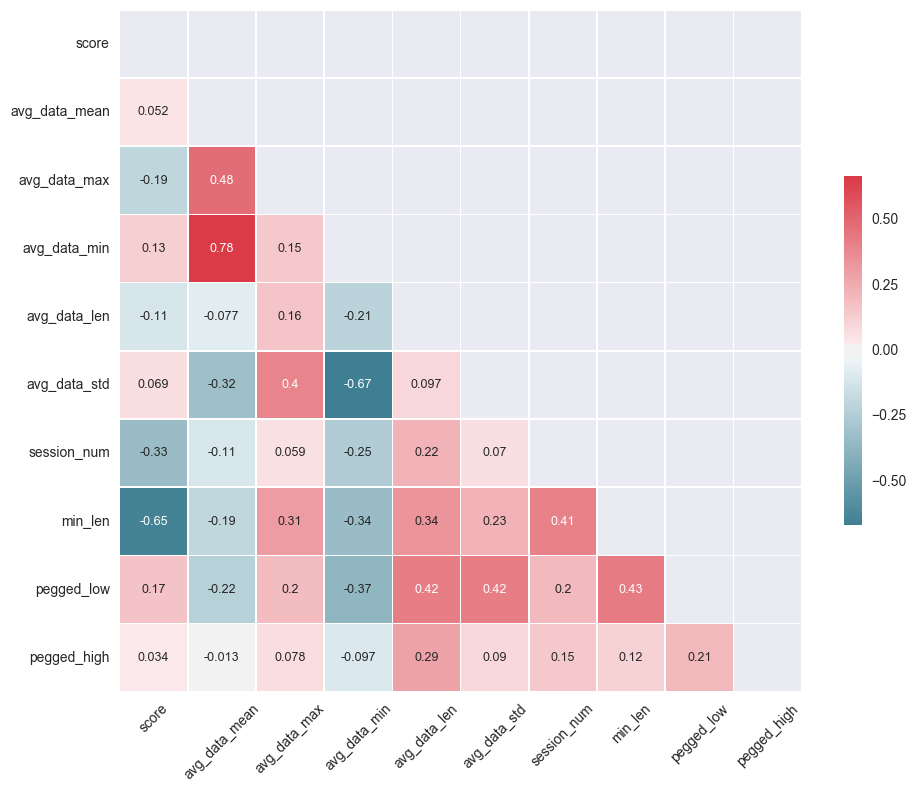

In [119]:
# Compute the correlation matrix
corr = df_results.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, annot_kws={"size": 9})
plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5]), <a list of 13 Text yticklabel objects>)

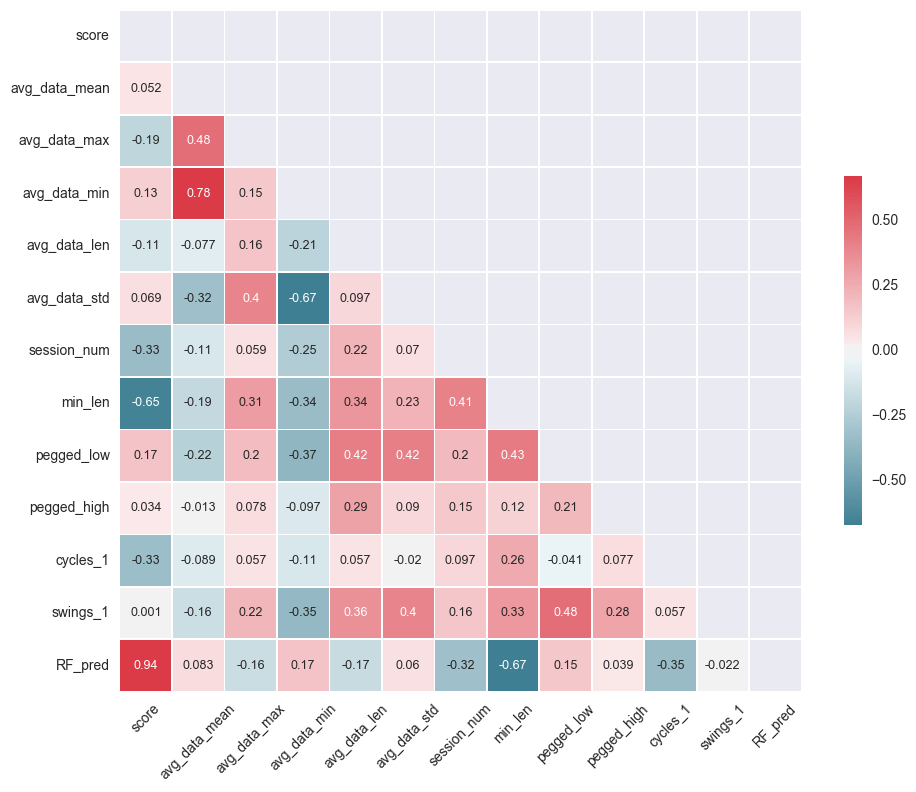

In [120]:
# Compute the correlation matrix
corr = df4.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, annot_kws={"size": 9})
plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5]), <a list of 12 Text yticklabel objects>)

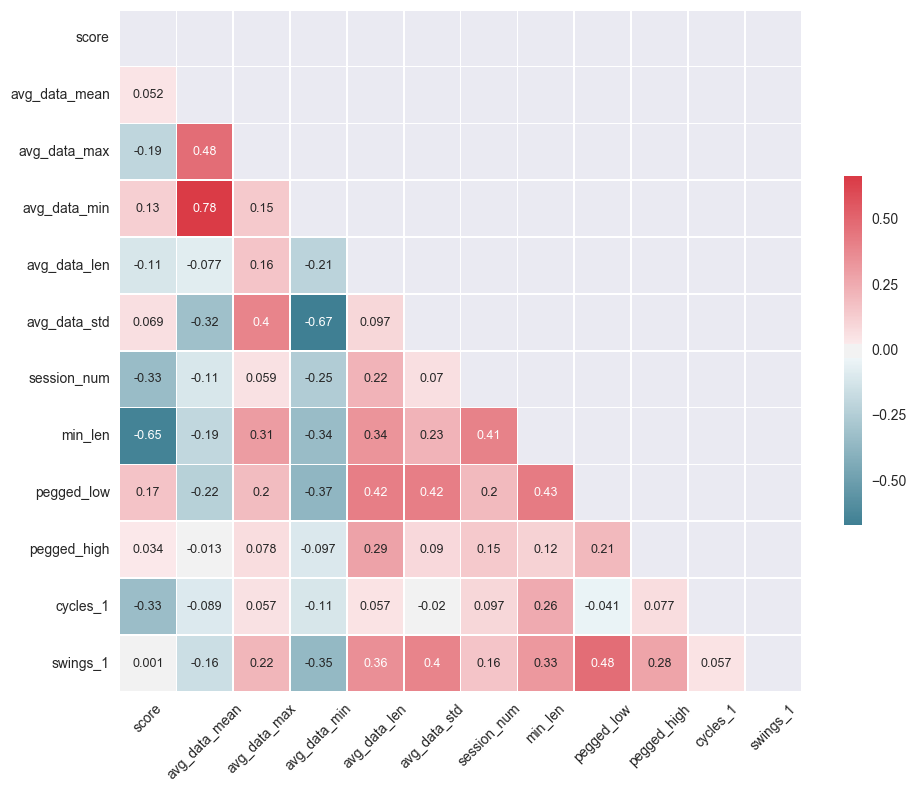

In [121]:
# Compute the correlation matrix
df9=df4.drop('RF_pred',axis=1)
corr = df9.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, annot_kws={"size": 9})
plt.xticks(rotation=45)
plt.yticks(rotation=0)

10 10
Feature ranking:
1. feature avg_data_len (0.251626)
2. feature cycles_1 (0.134859)
3. feature min_len (0.134769)
4. feature avg_data_std (0.105646)
5. feature avg_data_min (0.097373)
6. feature pegged_low (0.094684)
7. feature avg_data_mean (0.070648)
8. feature swings_1 (0.057275)
9. feature avg_data_max (0.050543)
10. feature pegged_high (0.002578)


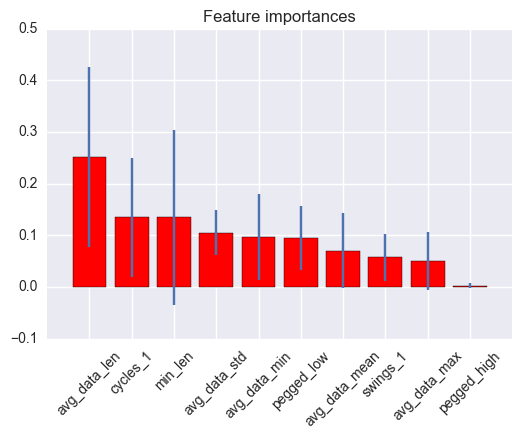

In [122]:
forest = clf_save
names = clf_name_save
X = X_save

importances = forest.feature_importances_
print len(importances), len(forest.feature_importances_)
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()
plt.savefig('feat-imp.png',bbox_inches='tight')